In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings("ignore")
X_train=pd.read_csv('XTrainTrans.csv')
X_test=pd.read_csv('XTestTrans.csv')
y_train=pd.read_csv('yTrainTrans.csv')
y_test=pd.read_csv('yTestTrans.csv')

In [2]:
X_train.columns

Index(['Latitude', 'Longitude', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA',
       ...
       'ThirdLargestPropertyUseType_33', 'ThirdLargestPropertyUseType_34',
       'ThirdLargestPropertyUseType_35', 'ThirdLargestPropertyUseType_36',
       'ThirdLargestPropertyUseType_37', 'ThirdLargestPropertyUseType_38',
       'ThirdLargestPropertyUseType_39', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)'],
      dtype='object', length=199)

In [3]:
y_train.columns

Index(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], dtype='object')

In [4]:
X_train.columns[:18]

Index(['Latitude', 'Longitude', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingType_0', 'BuildingType_1', 'BuildingType_2', 'BuildingType_3',
       'BuildingType_4', 'BuildingType_5', 'BuildingType_6'],
      dtype='object')

## On travaille sur la prediction de l'emission de CO2

In [5]:
y_train.columns

Index(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], dtype='object')

In [6]:
y_emissions=y_train['TotalGHGEmissions']

In [7]:
y_test_emissions=y_test['TotalGHGEmissions']

# Regressions lineaires
Nous allons commencer notre etudes des methodes de predictions des methodes les plus simples vers les plus performentes. Nous commencerons donc par les regressions lineaires

## 1- Dummy regression
On commence par cette regression qui predira uniquement la moyenne (c'est la pire regression possible et nous donnera donc une baseline)

In [8]:
import timeit
from sklearn import dummy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
dum = dummy.DummyRegressor(strategy='mean')

In [9]:
score=pd.DataFrame()


In [10]:
score.loc['Model',0]='Dummy'
start_time = timeit.default_timer()
dum.fit(X_train, y_emissions)
y_pred_dum = dum.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',0]=elapsed
print ("The time of execution is {:.5f}s".format(elapsed))

The time of execution is 0.00057s


In [11]:
def get_score(y, ypred,i):
    mse=mean_squared_error(y, ypred)
    score.loc['MSE', i]=mse
    print("MSE : {:.2f}".format(mse))
    rmse=np.sqrt(mse)
    score.loc['RMSE',i]= rmse
    print("RMSE : {:.2f}".format(rmse))
    mae=mean_absolute_error(y,ypred)
    score.loc['MAE', i]= mae
    print("MAE : {:.2f}".format(mae))


In [12]:
get_score(y_test_emissions, y_pred_dum,0)

MSE : 1.03
RMSE : 1.01
MAE : 0.81


In [13]:
score

,0
Model,Dummy
Time,0.000575
MSE,1.02734
RMSE,1.013578
MAE,0.807477


In [14]:
def get_r2(model,X,y,i):
    score.loc['R2',i]= model.score(X, y)
    print("R2 : {:.5f}".format(model.score(X, y)))

In [15]:
get_r2(dum, X_test, y_test_emissions,0)

R2 : -0.00044


## Conclusion: 
Dummy Regression nous donne le pire scenario, on voit bien q'avec un R2 negatif et des erreurs assez grande, ce model ne donne pas d'informations sur les predictions

## 2- Linear regression

In [16]:
score.loc['Model', 1]='Linear Regression'
from sklearn import linear_model
start_time = timeit.default_timer()
lr = linear_model.LinearRegression()
lr.fit(X_train,y_emissions)
y_pred_base=lr.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time', 1]=elapsed
print ("The time of execution is {:.5f}s".format(elapsed))

The time of execution is 0.03954s


In [17]:
get_score(y_test_emissions, y_pred_base,1)

MSE : 8323271811504648192.00
RMSE : 2885008112.90
MAE : 192488148.63


In [18]:
get_r2(lr,X_test, y_test_emissions,1)

R2 : -8105297949664456704.00000


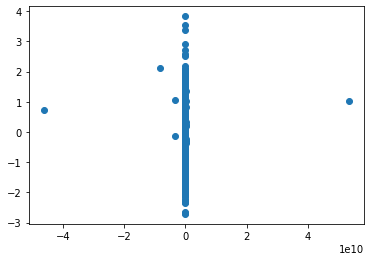

In [19]:
import matplotlib.pyplot as plt
plt.scatter(y_pred_base, y_test_emissions)

## Conclusion
La regression lineaire donne des resultats aberrants, pour mieux comprendre la cause de ces scores, on regardes les coefficients des variables de regression

### Coefficients des variables
Afin de comprendre l'importance des variables dans la prediction de la variable cible on regarde les coefficients de la regression. Je vais mettre les coefficients des regressions lineaire Ridge et Lasso dans un meme DataFrame afin de pouvoir comparer la performence et la decision de chaque methode

In [20]:
importance = lr.coef_

In [21]:
imp=pd.DataFrame()
imp['Feature']=X_train.columns
imp['LinearRegression']=importance

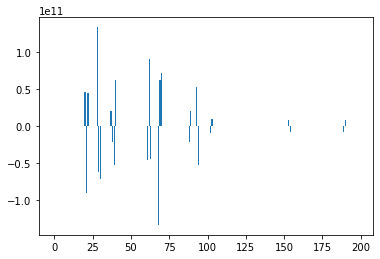

In [22]:
import matplotlib.pyplot as plt
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [23]:
imp.describe()

,LinearRegression
count,1.990000e+02
mean,4.914134e+07
std,2.167981e+10
min,-1.336779e+11
25%,-3.918655e-01
50%,2.674749e-02
75%,3.733493e-01
max,1.336779e+11


## Interpretation 
On voit bien ici que les resultats sont du aux gros poids des coefficients. En effet,  les coefficients ont des poids tres importants et donc agissent d'une facon extreme sur les predictions d'ou les scores tres importants dans les indicateurs d'erreurs. Cela est surtout du au fait qu'il existe des correlations entres les variables. Pour gerer la multicollinearite, on essaie les regressions Ridge et Lasso qui effectuent des regularisations sur l'erreur quadratique (l2) ou lineaire (l1)

In [24]:
negReg=imp.sort_values(by='LinearRegression').head(15)

In [25]:
posReg=imp.sort_values(by='LinearRegression', ascending=False).head(15)

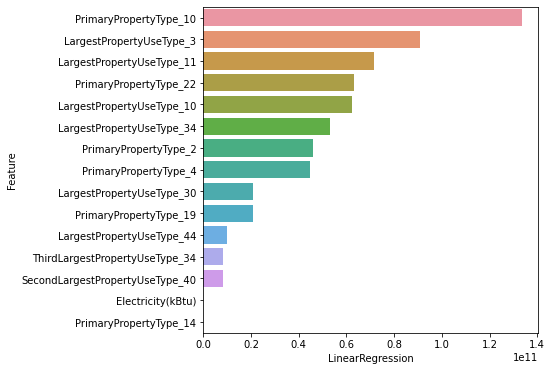

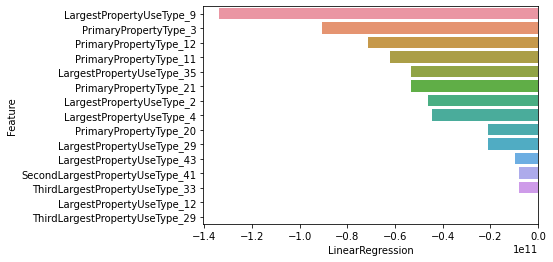

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='LinearRegression',y='Feature', data = posReg) 
plt.show()
ax=sns.barplot(x='LinearRegression',y='Feature', data = negReg) 

## 3- Regression ridge



Recherche des hyperparametres avec GridSearchCV

In [27]:
from sklearn.linear_model import Ridge
ridge=Ridge()
n_alphas = 300
alphas = np.logspace(-5, 5, n_alphas)
from sklearn.model_selection import GridSearchCV
param = {
    'alpha':alphas,
    'fit_intercept':[True,False],
          }
search = GridSearchCV(ridge, param, scoring='r2', n_jobs=-1, cv=5)


In [28]:
searchTable=pd.DataFrame()

In [29]:
searchTable.loc['Model',2]='Ridge'
start_time=timeit.default_timer()
result = search.fit(X_train, y_emissions)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',2]=elapsed
print ("The time of execution is {:.2f}s".format(elapsed))

The time of execution is 41.84s


In [30]:
def bestScore(model, i):
    searchTable.loc['Best Score',i]=model.best_score_
    #searchTable.loc['Best Hyperparameters',i]=model.best_params_
    print('Best Score: %s' % model.best_score_)
    print('Best Hyperparameters: %s' % model.best_params_)

In [31]:
bestScore(search,2)

Best Score: 0.7119298291482622
Best Hyperparameters: {'alpha': 4.156512558225988, 'fit_intercept': True}


In [32]:
Model= result.best_estimator_

In [33]:
score.loc['Model',2]='Ridge'
start_time=timeit.default_timer()
Model.fit(X_train,y_emissions)
ypredRidge=Model.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',2]=elapsed
print ("The time of execution is {:.2f}s".format(elapsed))

The time of execution is 0.04s


In [34]:
get_score(y_test_emissions,ypredRidge,2)

MSE : 0.30
RMSE : 0.54
MAE : 0.42


In [35]:
get_r2(Model,X_test, y_test_emissions, 2)

R2 : 0.71085


## Feature importances
On voit bien que le score de la regression Ridge presente une nette amelioration de la regression lineaire. Nous allons regarder les coefficients des variables par la regression Ridge

In [36]:
importance = Model.coef_
imp['Ridge']=importance


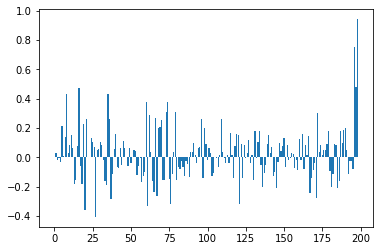

In [37]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [38]:
imp.describe()

,LinearRegression,Ridge
count,1.990000e+02,199.000000
mean,4.914134e+07,0.022626
std,2.167981e+10,0.175153
min,-1.336779e+11,-0.407123
25%,-3.918655e-01,-0.083271
50%,2.674749e-02,0.013258
75%,3.733493e-01,0.092415
max,1.336779e+11,0.942649


On voit bien que les coefficients dans la regression Ridge sont beaucoup plus equilibres

In [39]:
posRidge=imp[['Feature','Ridge']].sort_values(by="Ridge", ascending=False).head(10)

In [40]:
negRidge=imp[['Feature','Ridge']].sort_values(by="Ridge").head(10)

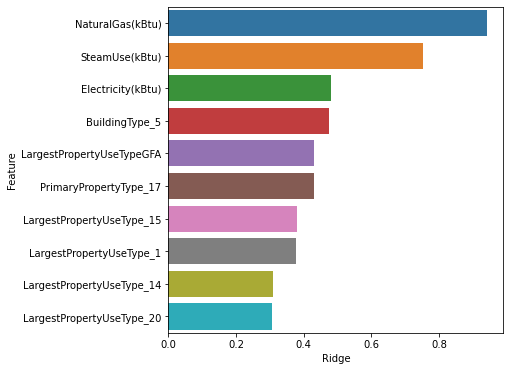

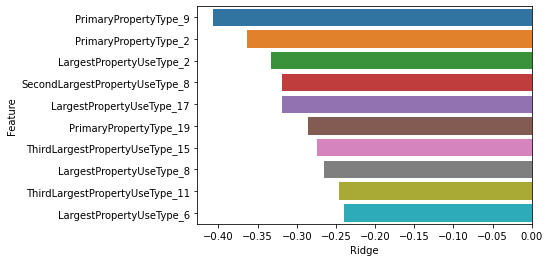

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='Ridge',y='Feature', data = posRidge) 
plt.show()
ax=sns.barplot(x='Ridge',y='Feature', data = negRidge) 

# Lasso
La regression Lasso permet de faire une selection de variables en eliminant des variables correlees. Nous allons comparer la performance de la regression Lasso a celle de Ridge

Recherche des hyperparametres avec GridSearchCV

In [42]:
from sklearn.linear_model import Lasso

n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)
param = {
    'alpha':alphas,
    'fit_intercept':[True,False],
          }
lasso=Lasso()
search = GridSearchCV(lasso, param, scoring='r2', n_jobs=-1, cv=5)


In [43]:
searchTable.loc['Model',3]='Lasso'
start_time=timeit.default_timer()
result = search.fit(X_train, y_emissions)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',3]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 210.19s


In [44]:
bestScore(search,3)

Best Score: 0.7084738305845787
Best Hyperparameters: {'alpha': 0.0010155211276345682, 'fit_intercept': True}


In [45]:
Model_lasso= result.best_estimator_

In [46]:
score.loc['Model',3]='Lasso'
start_time=timeit.default_timer()
Model_lasso.fit(X_train,y_emissions)
ypred_Lasso=Model_lasso.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',3]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))


The time of execution of above program is 0.47s


In [47]:
get_score(y_test_emissions,ypred_Lasso,3 )

MSE : 0.31
RMSE : 0.55
MAE : 0.43


In [48]:
get_r2(Model_lasso,X_test, y_test_emissions,3)

R2 : 0.70110


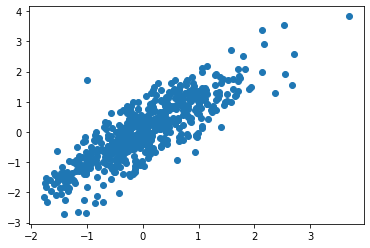

In [49]:
plt.scatter(ypred_Lasso,y_test_emissions )

## Conclusion
On voit bien que le score de la regression Lasso est tres proche du score de la regression Ridge, par contre le traietement des coefficients de variables est different

## Coefficients des variables Lasso

In [50]:
importance = Model_lasso.coef_

In [51]:
imp['Lasso']=importance

In [52]:
imp.describe()

,LinearRegression,Ridge,Lasso
count,1.990000e+02,199.000000,199.000000
mean,4.914134e+07,0.022626,0.028797
std,2.167981e+10,0.175153,0.182596
min,-1.336779e+11,-0.407123,-0.471920
25%,-3.918655e-01,-0.083271,0.000000
50%,2.674749e-02,0.013258,0.000000
75%,3.733493e-01,0.092415,0.005551
max,1.336779e+11,0.942649,1.382929


On voit bien ici que pour la regression Lasso il y a des variables dont le coefficient passe a 0. Il y a donc automatiquement une reduction du nombre de variables

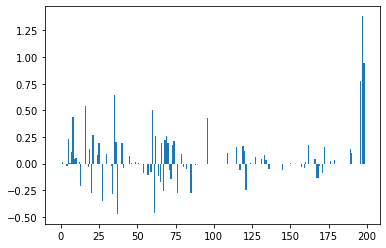

In [53]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [54]:
selected_Lasso=imp[(imp['Lasso']!=0)]['Feature'].values

In [55]:
len(selected_Lasso)

88

In [56]:
negLasso=imp[['Feature','Lasso']].sort_values(by='Lasso').head(10)

In [57]:
posLasso=imp[['Feature','Lasso']].sort_values(by='Lasso', ascending=False).head(10)

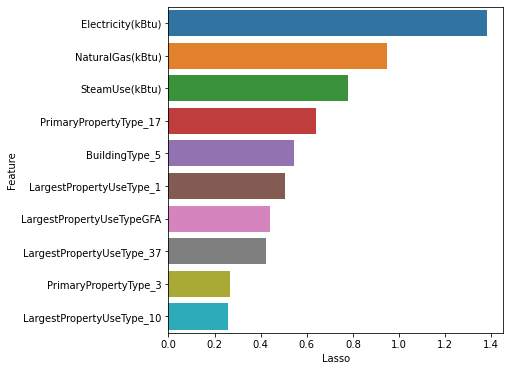

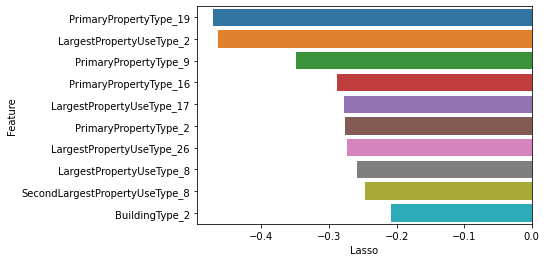

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
sns.barplot(x='Lasso',y='Feature', data = posLasso) 
plt.show()
sns.barplot(x='Lasso',y='Feature', data = negLasso) 
plt.show()

# 4- Decision tree regression

In [59]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()

In [60]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
from sklearn.model_selection import GridSearchCV
search=GridSearchCV(dtr,param_grid=parameters,scoring='r2',cv=3)

In [61]:
searchTable.loc['Model',4]='Decision Tree'
start_time=timeit.default_timer()
search.fit(X_train,y_emissions)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',4]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))


The time of execution of above program is 1434.75s


In [62]:
bestScore(search, 4)

Best Score: 0.5422897582983081
Best Hyperparameters: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}


In [63]:
best_tree = search.best_estimator_

In [64]:
score.loc['Model',4]='Decision Tree'
start_time=timeit.default_timer()
best_tree.fit(X_train, y_emissions)
y_pred_tree=best_tree.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',4]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 0.02s


In [65]:
get_score(y_test_emissions, y_pred_tree,4)

MSE : 0.45
RMSE : 0.67
MAE : 0.52


In [66]:
get_r2(best_tree, X_test, y_test_emissions, 4)

R2 : 0.56202


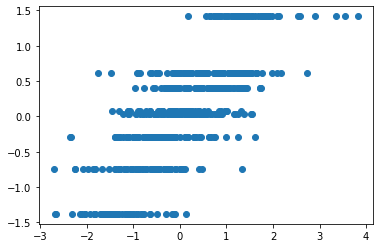

In [68]:
plt.scatter(y_test_emissions, y_pred_tree)

## Feature importance

In [69]:
importance=best_tree.feature_importances_

In [70]:
imp['Decision Tree']=importance

In [71]:
tree_feat=imp[['Feature','Decision Tree']][imp['Decision Tree']!=0].sort_values(by='Decision Tree', ascending=False)

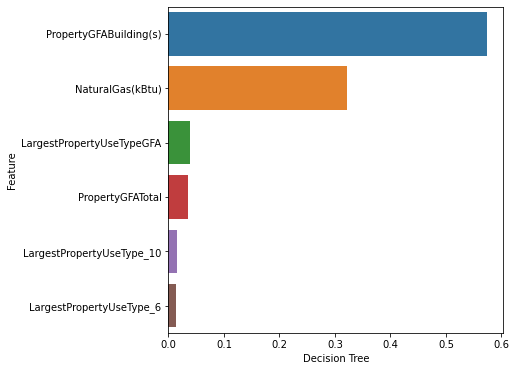

In [72]:
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='Decision Tree',y='Feature', data = tree_feat) 
plt.show()

# 5- Random Forest Regression

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()

In [74]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [75]:
search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [76]:
searchTable.loc['Model',5]='Random Forest'
start_time=timeit.default_timer()
search.fit(X_train, y_emissions)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',5]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))


Fitting 3 folds for each of 80 candidates, totalling 240 fits
The time of execution of above program is 1171.13s


In [77]:
bestScore(search, 5)

Best Score: 0.6932615715990532
Best Hyperparameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [78]:
best_forest = search.best_estimator_

In [79]:
score.loc['Model',5]='Random Forest'
start_time=timeit.default_timer()
best_forest.fit(X_train, y_emissions)
y_pred_forest=best_forest.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time', 5]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 18.65s


In [80]:
get_score(y_test_emissions, y_pred_forest,5)

MSE : 0.30
RMSE : 0.55
MAE : 0.41


In [81]:
get_r2(best_forest, X_test, y_test_emissions, 5)

R2 : 0.70785


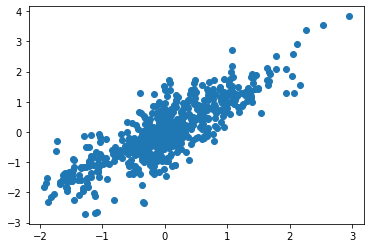

In [82]:
plt.scatter(y_pred_forest, y_test_emissions)

## Feature importance

In [83]:
importance=best_forest.feature_importances_
imp['Random Forest']=importance
imp.describe()

,LinearRegression,Ridge,Lasso,Decision Tree,Random Forest
count,1.990000e+02,199.000000,199.000000,199.000000,199.000000
mean,4.914134e+07,0.022626,0.028797,0.005025,0.005025
std,2.167981e+10,0.175153,0.182596,0.046720,0.025272
min,-1.336779e+11,-0.407123,-0.471920,0.000000,0.000000
25%,-3.918655e-01,-0.083271,0.000000,0.000000,0.000054
50%,2.674749e-02,0.013258,0.000000,0.000000,0.000241
75%,3.733493e-01,0.092415,0.005551,0.000000,0.000981
max,1.336779e+11,0.942649,1.382929,0.574490,0.214049


In [111]:
forest_feat=imp[['Feature', 'Random Forest']].sort_values(by='Random Forest', ascending=False).head(10)

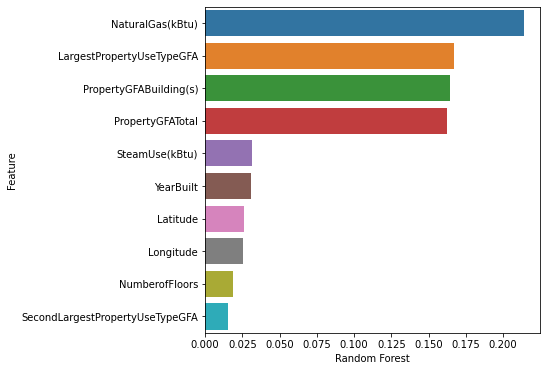

In [112]:
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='Random Forest',y='Feature', data = forest_feat) 
plt.show()

# 6- XgBoost

In [86]:
import xgboost as xgb
from scipy.stats import uniform,loguniform, randint

In [87]:
param_grid = {
    "learning_rate": [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
    "n_estimators": [200, 500, 1000, 1500, 2000]
}

# Random
search = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=param_grid,
                        n_iter = 80,  cv=3, n_jobs=8, scoring='r2')

In [88]:
searchTable.loc['Model', 6]='XgBoost'
start_time=timeit.default_timer()
model_xgboost = search.fit(X_train, y_emissions)
elapsed = timeit.default_timer() - start_time
searchTable.loc['Search Time',6]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 832.49s


In [89]:
bestScore(model_xgboost, 6)

Best Score: 0.7047475484963314
Best Hyperparameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.3}


In [90]:
best_boost= model_xgboost.best_estimator_

In [91]:
score.loc['Model',6]='XgBoost'
start_time=timeit.default_timer()
best_boost.fit(X_train, y_emissions)
ypreds_boost = best_boost.predict(X_test)
elapsed = timeit.default_timer() - start_time
score.loc['Time',6]=elapsed
print ("The time of execution of above program is {:.2f}s".format(elapsed))

The time of execution of above program is 0.87s


In [92]:
get_score(y_test_emissions, ypreds_boost,6)

MSE : 0.30
RMSE : 0.54
MAE : 0.41


In [93]:
get_r2(best_boost,X_test, y_test_emissions, 6)

R2 : 0.71139


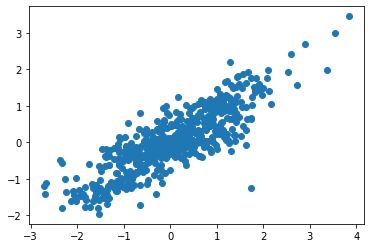

In [94]:
plt.scatter(y_test_emissions, ypreds_boost)

In [95]:
importance=best_boost.feature_importances_
imp['XgBoost']=importance
imp.describe()

,LinearRegression,Ridge,Lasso,Decision Tree,Random Forest,XgBoost
count,1.990000e+02,199.000000,199.000000,199.000000,199.000000,199.000000
mean,4.914134e+07,0.022626,0.028797,0.005025,0.005025,0.005025
std,2.167981e+10,0.175153,0.182596,0.046720,0.025272,0.011576
min,-1.336779e+11,-0.407123,-0.471920,0.000000,0.000000,0.000000
25%,-3.918655e-01,-0.083271,0.000000,0.000000,0.000054,0.000000
50%,2.674749e-02,0.013258,0.000000,0.000000,0.000241,0.001657
75%,3.733493e-01,0.092415,0.005551,0.000000,0.000981,0.004337
max,1.336779e+11,0.942649,1.382929,0.574490,0.214049,0.122045


In [96]:
xgb_feat=imp[['Feature','XgBoost']][imp['XgBoost']>0.01].sort_values(by='XgBoost', ascending=False).head(10)

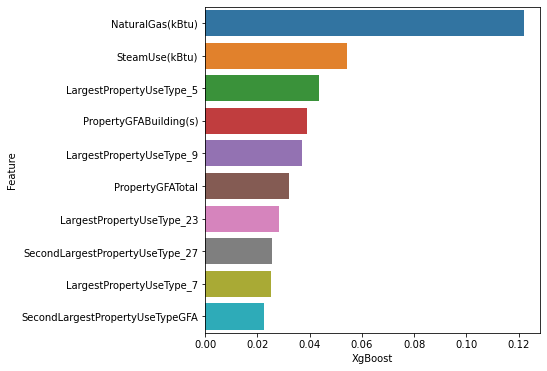

In [97]:
fig = plt.figure(figsize=(6, 6))
#ax = fig.add_subplot(1,2,2)
ax=sns.barplot(x='XgBoost',y='Feature', data = xgb_feat) 
plt.show()

# Synthese des resultats de performence

## Scores de validation sur Test set

In [99]:
score=score.transpose()
score1=score.drop(columns=['MSE', 'MAE'])
score1.transpose()

,0,1,2,3,4,5,6
Model,Dummy,Linear Regression,Ridge,Lasso,Decision Tree,Random Forest,XgBoost
Time,0.000575,0.039536,0.037938,0.467231,0.0179,18.647228,0.865007
RMSE,1.013578,2885008112.90101,0.544909,0.554016,0.670638,0.547728,0.5444
R2,-0.000435,-8105297949664456704.0,0.71085,0.701105,0.562023,0.707851,0.71139


## Temps de recherche des hyperparametres et score R2 par validation croisee sur train set

In [100]:
searchTable

,2,3,4,5,6
Model,Ridge,Lasso,Decision Tree,Random Forest,XgBoost
Search Time,41.837421,210.189438,1434.754854,1171.13446,832.490669
Best Score,0.71193,0.708474,0.54229,0.693262,0.704748


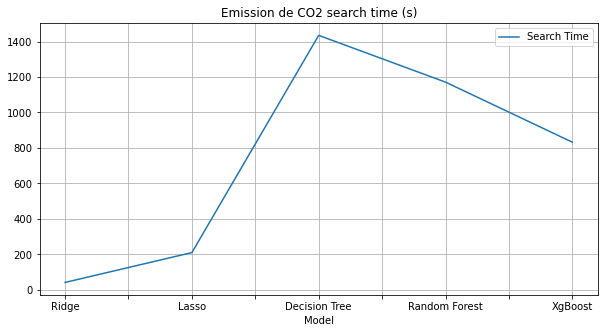

In [102]:
searchTable=searchTable.transpose()
ax=searchTable[["Model","Search Time"]].plot(kind="line", x="Model", figsize=(10,5), grid=True, title="Emission de CO2 search time (s)")

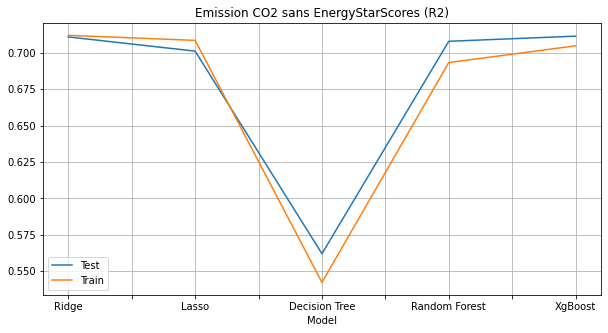

In [104]:
comparaison=pd.DataFrame()
comparaison['Model']=searchTable['Model']
comparaison['Test']=score['R2']
comparaison['Train']=searchTable['Best Score']
ax=comparaison.plot(kind="line", x="Model", figsize=(10,5), grid=True, title="Emission CO2 sans EnergyStarScores (R2)")

In [105]:
score.to_csv('scoreEmission.csv')

In [106]:
searchTable.to_csv("searchTableEmission.csv")